In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sem
import scipy.linalg as la

In [2]:
N = 16
p = N - 1
E = 8
Al, Bl, Cl, Dl, zl, wl = sem.semhat(p)
Q = np.zeros((N*E, p*E))
for j in range(E):
    for i in range(N):
        if i+j*p == p*E:
            continue
        Q[i+j*N,i+j*p] = 1
Q[-1,0] = 1
Qt = Q.transpose()
A = np.dot(Qt, np.dot(np.kron(np.identity(E), Al), Q))
B = np.dot(Qt, np.dot(np.kron(np.identity(E), Bl), Q)) / E
D = np.dot(Qt, np.dot(np.kron(np.identity(E), Dl), Q)) * E
A = np.dot(D.transpose(), np.dot(B, D))
C = np.dot(B, D) 
z = np.zeros(p * E )
for j in range(E):
    z[j*p:(j+1)*p] = zl[:-1] + 2*j
z = (z - (E-1))/E

In [3]:
def bdf1(dt, x):
    y = la.solve(B - dt * (C-visc*A), np.dot(B, x[:,0]))
    #f = np.dot(A, x) #+ np.dot(Cl, x)
    #y = x + dt * f
    return y

def bdf2(dt, x):
    rhs = np.dot(B, 4./3.*x[:,0]- 1./3.*x[:,1])
    scale = 2.*dt/3.
    y = la.solve(B - scale * (C-visc*A), rhs )
    return y

def bdf3(dt, x):
    rhs = np.dot(B, 18./11.*x[:,0]- 9./11.*x[:,1] + 2./11.*x[:,2])
    scale = 6.*dt/11.
    y = la.solve(B - scale * (C-visc*A), rhs )
    return y

def bdf4(dt, x):
    rhs = np.dot(B, 48./25.*x[:,0]- 36./25.*x[:,1] + 16./25.*x[:,2] - 3./25. * x[:,3])
    scale = 12.*dt/25.
    y = la.solve(B - scale * (C-visc*A), rhs )
    return y

def bdf5(dt, x):
    rhs = np.dot(B, 300./137.*x[:,0]- 300./137.*x[:,1] + 200./137.*x[:,2] - 75./137. * x[:,3] + 12./137. * x[:,4])
    scale = 60.*dt/137.
    y = la.solve(B - scale * (C-visc*A), rhs )
    return y

def bdf2opt(dt, x):
    beta = 0.48
    rhs_2 = 4./3.*x[:,0]- 1./3.*x[:,1]
    rhs_3 = 18./11.*x[:,0]- 9./11.*x[:,1] + 2./11.*x[:,2]
    rhs = np.dot(B, beta*rhs_3 + (1-beta)*rhs_2)
    scale = beta * 6.*dt/11. + (1-beta) * 2.*dt/3.
    y = la.solve(B - scale * (C-visc*A), rhs )
    return y

In [4]:
def simulate(IC, Cycles, dt, advance):
    NT = int(Cycles * 2 / dt)
    
    dat = np.zeros((IC.size, 5))
    dat[:,0] = IC
    
    adv = bdf1(dt, dat)
    dat = np.roll(dat, 1, 1)
    dat[:,0] = adv
    
    adv = bdf2(dt, dat)
    dat = np.roll(dat, 1, 1)
    dat[:,0] = adv

    for i in range(NT-2):
        adv = advance(dt, dat)
        dat = np.roll(dat, 1, 1)
        dat[:,0] = adv
        
    return adv



def calculate_error(IC, ref, Cycles, dt, advance):
    out = simulate(IC, Cycles, dt, advance)
        
    #err = np.exp(-np.square(z)/(4*visc*(2*Num + delta/(4*visc)) )) - bar
    err = ref - out
    norm = np.sqrt(np.dot(err.transpose(), np.dot(B, err)))
    return norm

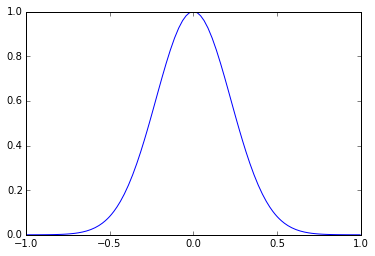

In [5]:
delta = .1
IC = np.exp(-np.square(z)/delta)
plt.plot(z, IC)

In [6]:
Cycles = 8
Re = 512
visc = 2 / Re

nsamp = 9

ref = simulate(IC, Cycles, 2.**(-(nsamp + 2)), bdf2)


dts = np.power(2., np.arange(0, -nsamp, -1))
errs_2 = np.zeros(nsamp)
errs_2o = np.zeros(nsamp)
errs_3 = np.zeros(nsamp)
errs_4 = np.zeros(nsamp)
errs_5 = np.zeros(nsamp)
for i in range(nsamp):
    errs_2[i]  = calculate_error(IC, ref, Cycles, dts[i], bdf2)
    errs_2o[i] = calculate_error(IC, ref, Cycles, dts[i], bdf2opt)
    errs_3[i]  = calculate_error(IC, ref, Cycles, dts[i], bdf3)
    errs_4[i]  = calculate_error(IC, ref, Cycles, dts[i], bdf4)
    errs_5[i]  = calculate_error(IC, ref, Cycles, dts[i], bdf5)


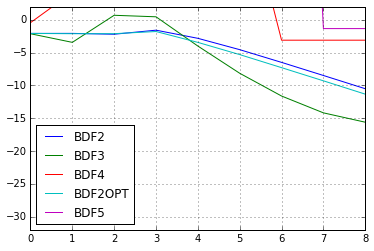

In [7]:
plt.plot(-np.log2(dts), np.log2(errs_2), label="BDF2")
plt.plot(-np.log2(dts), np.log2(errs_3), label="BDF3")
plt.plot(-np.log2(dts), np.log2(errs_4), label="BDF4")
plt.plot(-np.log2(dts), np.log2(errs_2o),label="BDF2OPT")
plt.plot(-np.log2(dts), np.log2(errs_5), label="BDF5")
plt.grid(True);
plt.ylim(ymax=2., ymin=-32);
plt.legend(loc=3);

In [8]:
# from https://commons.wikimedia.org/wiki/File:Stability_region_for_BDF1.svg
BFDcoeffs = { 1: {'alpha': [1, -1], 'beta': 1},
              2: { 'alpha': [3, -4, 1], 'beta': 2 },
              3: { 'alpha': [11, -18, 9, -2], 'beta': 6 },
              4: { 'alpha': [25, -48, 36, -16, 3], 'beta': 12 },
              5: { 'alpha': [137, -300, 300, -200, 75, -12], 'beta': 60 },
              6: { 'alpha': [147, -360, 450, -400, 225, -72], 'beta': 60 } }

# Returns > 1 if argument is not in region of absolute stability
def stabilityFunction(hTimesLambda, s):
    stabPolyCoeffs = list(BFDcoeffs[s]['alpha'])
    stabPolyCoeffs[0] -= hTimesLambda * BFDcoeffs[s]['beta']
    return max(abs(np.roots(stabPolyCoeffs)))

In [9]:
def plot_stability(Re, dt, s):
    plt.plot(z, IC)
    plt.plot(z, ref)
    plt.plot(z, simulate(IC, Cycles, dt, bdf3))
    plt.grid(True)
    
    ev = la.eigvals(dt*(C-visc*A), B)

    x = np.linspace(np.min(np.real(ev)),5, num=200)
    y = np.linspace(0,np.max(np.imag(ev)), num=200)
    [X,Y] = np.meshgrid(x,y)
    Z = np.zeros(X.shape)
    for m in range(X.shape[0]):
        for n in range(X.shape[1]):
            Z[m,n] = stabilityFunction(X[m,n] + 1j * Y[m,n], s)

    unstable_ev = []
    for m in range(ev.shape[0]):
        foo = stabilityFunction(ev[m], s)
        if foo > 1.0:
            unstable_ev.append(ev[m])
            print("({:f}, {:f}) unstable with z = 1 + {:e}".format(ev[m].real, ev[m].imag, foo-1.))
    unstable = np.array(unstable_ev)
    
    plt.figure(figsize=(10, 10))
    plt.contour(X, Y, Z, [1], colors='k')
    plt.contourf(X, Y, Z, [0,1], colors=[[1, 0.5, 0.8]])

    plt.scatter(np.real(ev), np.imag(ev))
    plt.scatter(np.real(unstable), np.imag(unstable), color='r')

    plt.ylim(ymin=np.min(np.imag(ev))*1.1, ymax=np.max(np.imag(ev))*1.1)

(-0.060814, 0.984548) unstable with z = 1 + 3.591421e-03
(-0.060814, -0.984548) unstable with z = 1 + 3.591421e-03
(-0.038914, 0.787734) unstable with z = 1 + 3.540204e-03
(-0.038914, -0.787734) unstable with z = 1 + 3.540204e-03
(0.000000, 0.000000) unstable with z = 1 + 4.705125e-13


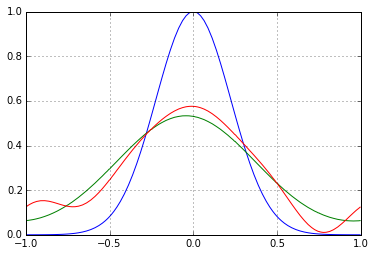

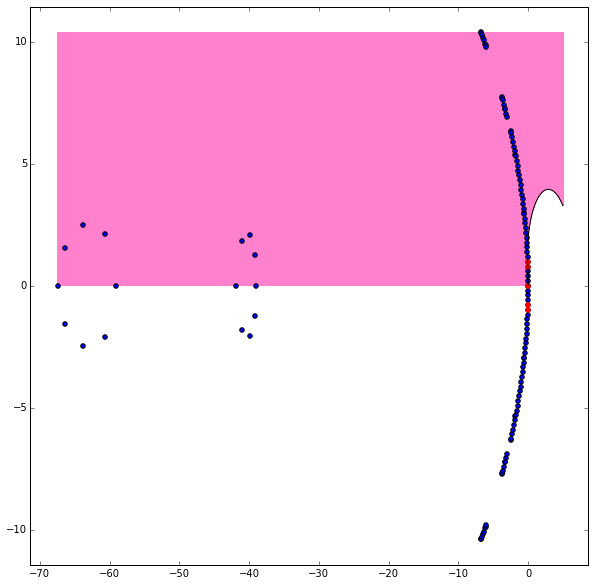

In [10]:
plot_stability(2048, 1./16, 3)